In [100]:
# Import Modules
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as st

# Import Data
df = pd.read_csv("../data/13222067_cleaned.csv")
df.head()

,jenis_kelamin,usia,pendidikan,pekerjaan,penghasilan,domisili,durasi_internet,aktivitas_online_meningkat,aktivitas_online_meningkat_3bln,layanan_aktif_1,...,bayar_online_5,bayar_online_6,bayar_online_7,bayar_online_8,keluhan_online_1,keluhan_online_2,keluhan_online_3,keluhan_online_4,keluhan_online_5,keluhan_online_6
0,Pria,47,SMA,Pekerja Serabutan,Rp 2 juta – Rp 5 juta,bandung,3.0,Sama saja,NaN,Mobile Banking,...,NaN,NaN,Melalui minimarket,NaN,Barang yang diperoleh tidak sesuai dengan spes...,Barang rusak/ salah tetapi tidak dapat dikemba...,NaN,NaN,NaN,NaN
1,Wanita,19,SMA,Pelajar / Mahasiswa,< Rp 2 juta,surabaya,10.0,Ya,Keperluan mengerjakan tugas,Mobile Banking,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Pria,50,S1,Karyawan Swasta,Rp 5 juta – Rp 10 juta,jakarta,6.0,Ya,Melakukan video conference,Mobile Banking,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Wanita,19,SMA,Pelajar / Mahasiswa,< Rp 2 juta,bandung,5.0,Ya,Mengikuti kelas online,Mobile Banking,...,NaN,NaN,NaN,NaN,Barang yang diperoleh tidak sesuai dengan spes...,Barang rusak/ salah tetapi tidak dapat dikemba...,NaN,NaN,NaN,NaN
4,Pria,28,S1,Karyawan Swasta,Rp 5 juta – Rp 10 juta,bandung,9.0,Sama saja,NaN,Mobile Banking,...,Transfer via ATM,NaN,NaN,NaN,NaN,NaN,Pembayaran sudah dilakukan; barang tidak tersedia,NaN,Pembayaran telah dilakukan tetapi tidak terdet...,NaN


In [4]:
def countToSeries(df, column, normalize=True, threshold=0, otherLabel="lain"):
    value_count = df[column].value_counts(normalize=normalize)
    total = value_count.sum()
    newSeries = {}
    for idx, val in value_count.items():
        if(val/total < threshold/100):
            if(otherLabel in newSeries):
                newSeries[otherLabel] += val
            else:
                newSeries[otherLabel] = 0
        else:
            newSeries[idx] = val
    series1 = pd.Series(newSeries)
    return series1

def multipleChoiceToSeries(df, column_list, normalize=True):
    value_counts = {}
    total = df[column_list[0]].shape[0]
    for col in column_list:
        value_count = df[col].value_counts(dropna=True) 
        key = value_count.keys().tolist()[0]
        val = value_count.tolist()[0]
        if(normalize):
            value_counts[key] = val/total
        else:
            value_counts[key] = val
    value_counts_series = pd.Series(value_counts)
    return value_counts_series

In [84]:
# Confidence Interval On Sample
def ci_p2(x1, x2, n1, n2, alpha=0.05, H1="!="):
    phat1 = x1/n1
    phat2 = x2/n2
    phat = (x1+x2)/(n1+n2)
    z_alpha = st.norm.ppf(1-alpha)
    z_halfAlpha = st.norm.ppf(1-(alpha/2))
    z = (phat1-phat2)/(phat*(1-phat)*(1/n1 + 1/n2))**0.5

    confint_err = z_halfAlpha*(phat1*(1-phat1)/n1 + phat2*(1-phat2)/n2)**0.5
    if(H1=="<" and z<z_alpha):
        conclusion = "Reject H0 (H1: z < -za)"
    elif(H1==">" and z>z_alpha):
        conclusion = "Reject H0 (H1: p1-p1 > 0)"
    elif(H1=="!=" and z<z_halfAlpha and z<z_halfAlpha):
        conclusion = "Reject H0 (H1: p1-p2 != 0)"
    else:
        conclusion = "Failed To Reject H0"
    return (z, [phat-confint_err, phat+confint_err], conclusion)

# Chi Square Independence
def chiSqTest(df_cont, alpha=0.05): # Basically, Is the value of A affects B?
    Ei = df_cont.copy()
    for s in df_cont.index:
        for o in df_cont.columns:
            Ei.loc[s,o] = df_cont.loc[s].sum() * df_cont.loc[:,o].sum() / df_cont.values.sum()
        
    row, col = df_cont.shape
    df = (row-1)*(col-1)
    chi2 = ((df_cont - Ei)**2/Ei).sum().sum()
    chi2_alpha = st.chi2.ppf(1-alpha, df)
    pval = 1 - st.chi2.cdf(chi2, df)

    # Conclusion
    if(chi2 < chi2_alpha):
        conclusion = "Fail to Reject H0"
    else:
        conclusion = "Reject H0"
    # ans = "P-Value: {}\nchi2: {}\n Critical Region: chi2 > {}\nConclusion: {}".format(pval, chi2, chi2_alpha, conclusion)
    return (pval, [chi2, chi2_alpha], conclusion)

In [85]:
emoney_pilihan_cols = ["emoney_pilihan1", "emoney_pilihan2", "emoney_pilihan3", "emoney_pilihan4", "emoney_pilihan5", "emoney_pilihan6"
        , "emoney_pilihan7", "emoney_pilihan8", "emoney_pilihan9", "emoney_pilihan10", "emoney_pilihan11"]
emoney_series = multipleChoiceToSeries(df, emoney_pilihan_cols, normalize=False)
bank_cols = ["bank_1", "bank_2", "bank_3", "bank_4", "bank_5", "bank_6", "bank_7"]
bank_series = multipleChoiceToSeries(df, bank_cols, normalize=False)

print("Bank BCA - Bank BNI")
print(ci_p2(bank_series["Bank BCA"], bank_series["Bank BNI"], df.shape[0], df.shape[0], H1=">"))
print("Bank BCA - Bank Mandiri")
print(ci_p2(bank_series["Bank BCA"], bank_series["Bank Mandiri"], df.shape[0], df.shape[0], H1=">"))
print("Bank Mandiri - Bank BNI")
print(ci_p2(bank_series["Bank Mandiri"], bank_series["Bank BNI"], df.shape[0], df.shape[0], H1=">"))


print("GoPay-ShopeePay")
print(ci_p2(emoney_series["GoPay"], emoney_series["ShopeePay"], df.shape[0], df.shape[0], H1=">"))
print("GoPay-OVO")
print(ci_p2(emoney_series["GoPay"], emoney_series["OVO"], df.shape[0], df.shape[0], H1=">"))
print("ShopeePay-OVO")
print(ci_p2(emoney_series["ShopeePay"], emoney_series["OVO"], df.shape[0], df.shape[0], H1=">"))

Bank BCA - Bank BNI
(8.5202864568461, [0.3211628768400581, 0.4705037898266085], 'Reject H0 (H1: p1-p1 > 0)')
Bank BCA - Bank Mandiri
(7.17141596790777, [0.34489809835568996, 0.49885190164431004], 'Reject H0 (H1: p1-p1 > 0)')
Bank Mandiri - Bank BNI
(1.4467401488916483, [0.17783256917355078, 0.318695208604227], 'Failed To Reject H0')
GoPay-ShopeePay
(3.909931337258369, [0.5980500580565418, 0.7491721641656806], 'Reject H0 (H1: p1-p1 > 0)')
GoPay-OVO
(3.490229851667315, [0.6070558703411928, 0.7575274629921405], 'Reject H0 (H1: p1-p1 > 0)')
ShopeePay-OVO
(-0.4263395318436457, [0.526103039173372, 0.6857025163821836], 'Failed To Reject H0')


In [139]:
def createCont(cols1, cols2):
    vals1 = []
    vals2 = []
    for col in cols1:
        vals1.append(df[col].value_counts().index.tolist()[0])
    for col in cols2:
        vals2.append(df[col].value_counts().index.tolist()[0])
    newDict  = {}
    for x1 in cols1:
        for x2 in cols2:
            df_filtered = df.dropna(subset=[x1, x2])
            val = df_filtered.shape[0]
            if(x2 not in newDict):
                newDict[x2] = {}
            newDict[x2][x1] = val
    cont = pd.DataFrame(newDict)
    cont = cont.set_axis(vals1, axis="index")
    cont = cont.set_axis(vals2, axis="columns")

    normalized_df = cont.div(cont.sum(axis=1), axis=0)
    normalized_df.plot(kind="bar", stacked=True)
            
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return cont

def createCont2(col1, cols2):
    # vals1 = df[col1].value_counts().index.tolist() 
    df_copy = df.copy()
    df_copy[col1] = pd.cut(df_copy[col1], bins=[10,18,25,40,70])
    vals1 = df_copy[col1].value_counts().index.tolist() 
    vals2 = []
    for col in cols2:
        vals2.append(df[col].value_counts().index.tolist()[0])
    newDict  = {}
    for x1 in vals1:
        for x2 in cols2:
            df_filtered = df.dropna(subset=[x2])
            df_filtered = df_filtered.loc[df_copy[col1] == x1]
            val = df_filtered.shape[0]
            if(x2 not in newDict):
                newDict[x2] = {}
            newDict[x2][x1] = val
    cont = pd.DataFrame(newDict)
    cont = cont.set_axis(vals1, axis="index")
    cont = cont.set_axis(vals2, axis="columns")

    normalized_df = cont.div(cont.sum(axis=0), axis=1)
    normalized_df.T.plot(kind="bar", stacked=True)
            
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return cont

bank-keluhan
(0.760105711705991, [13.515169438271561, 28.869299430392623], 'Fail to Reject H0')
emoney-keluhan
(0.10185784065878578, [36.6464630603488, 40.113272069413625], 'Fail to Reject H0')
usia-emoney
(5.54740084646177e-07, [78.89468263519892, 40.113272069413625], 'Reject H0')
usia-bank
(0.03851705550692486, [29.891273202551936, 28.869299430392623], 'Reject H0')
bank-emoney
(0.004633820546816603, [84.8676405823883, 72.15321616702309], 'Reject H0')


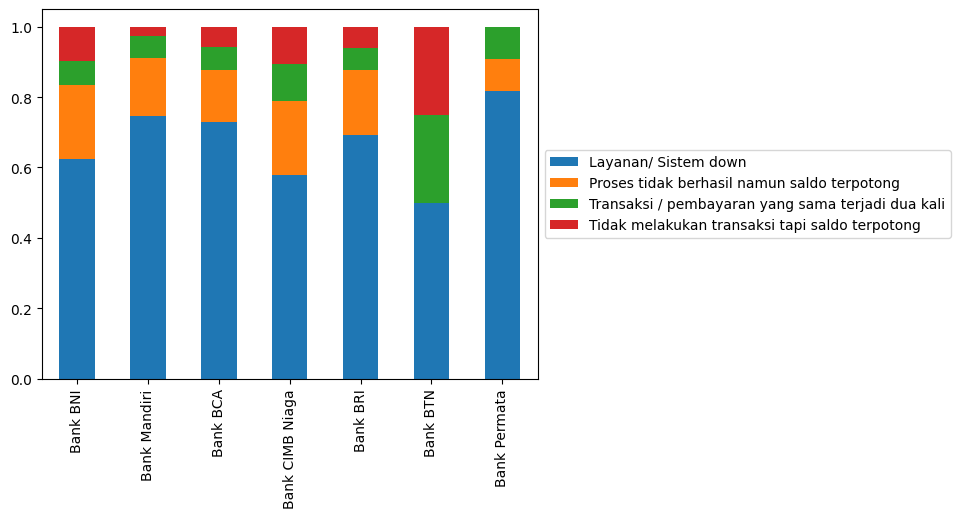

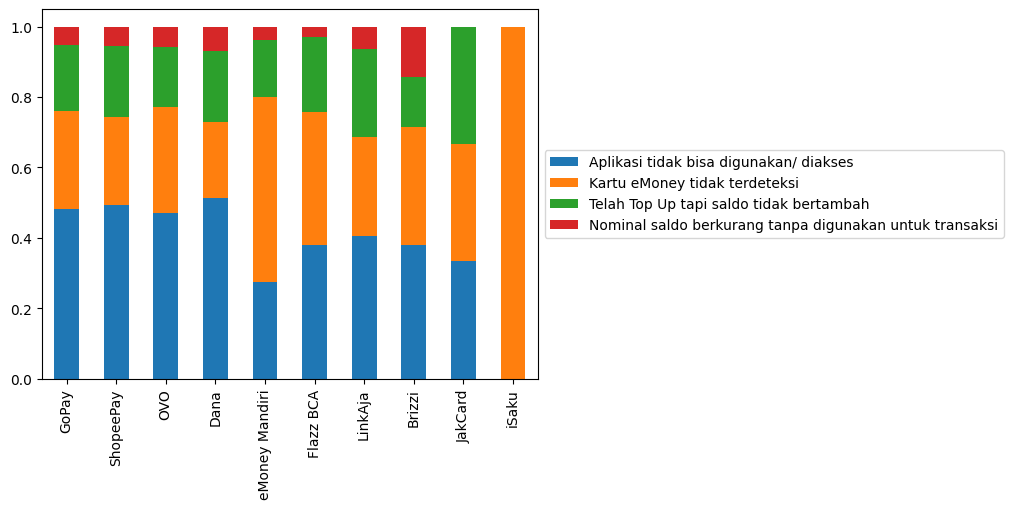

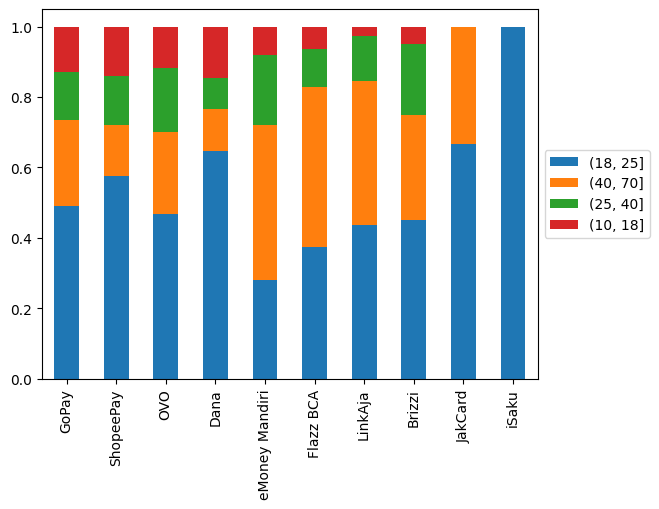

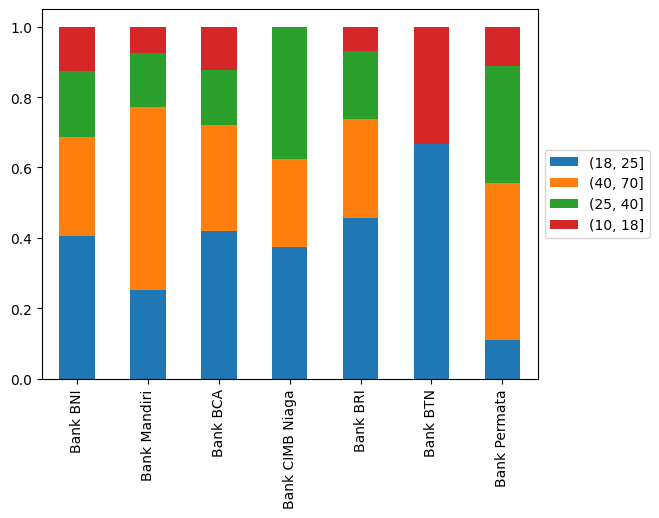

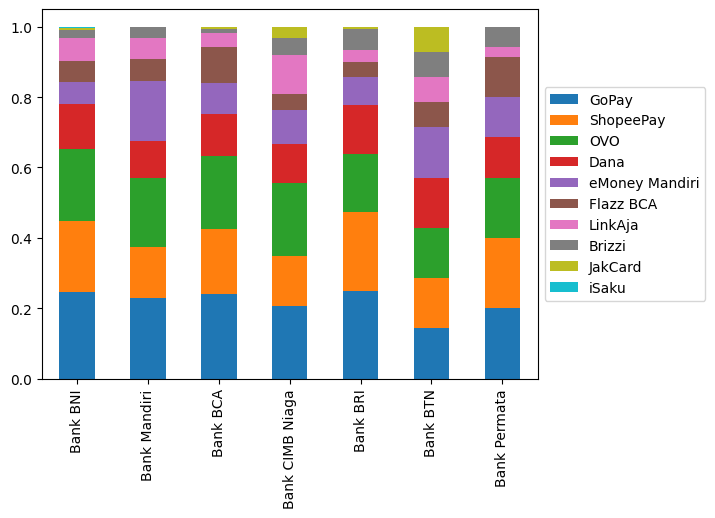

In [140]:
emoney_pilihan_cols = ["emoney_pilihan1", "emoney_pilihan2", "emoney_pilihan3", "emoney_pilihan4", "emoney_pilihan5", "emoney_pilihan6"
        , "emoney_pilihan7", "emoney_pilihan9", "emoney_pilihan10", "emoney_pilihan11"]
keluhan_emoney_cols = ["keluhan_emoney_1", "keluhan_emoney_2", "keluhan_emoney_3", "keluhan_emoney_4"]
bank_cols = ["bank_1", "bank_2", "bank_3", "bank_4", "bank_5", "bank_6", "bank_7"]
keluhan_cols = ["keluhan_1", "keluhan_2", "keluhan3", "keluhan 4"]




print("bank-keluhan")
print(chiSqTest(createCont(bank_cols, keluhan_cols)))
print("emoney-keluhan")
print(chiSqTest(createCont(emoney_pilihan_cols, keluhan_emoney_cols)))

# print("keluhan-bank")
# print(chiSqTest(createCont(keluhan_cols, bank_cols)))
# print("keluhan-emoney")
# print(chiSqTest(createCont(keluhan_emoney_cols, emoney_pilihan_cols).drop(['Tidak Menggunakan eMoney'], axis=1)))

print("usia-emoney")
print(chiSqTest(createCont2("usia", emoney_pilihan_cols)))
print("usia-bank")
print(chiSqTest(createCont2("usia", bank_cols)))
print("bank-emoney")
print(chiSqTest(createCont(bank_cols, emoney_pilihan_cols)))
# mau ngetest aja chisquarenya beneran ada ato ngk
